In [1]:
import geopandas as gpd
from shapely.strtree import STRtree
import networkx as nx
from src.constants import GWS_DATA_DIR
veg_data = gpd.read_file(GWS_DATA_DIR / "chernobyl_habitat_data" / "Vegetation_mape.shp")

In [2]:
veg_data

Vegetation       AREA  \
0               1   24.85380   
1               1    7.91757   
2               1    7.86063   
3               1   10.45270   
4               1    7.52688   
...           ...        ...   
14905          77    9.88831   
14906          77    5.99406   
14907          77    9.59274   
14908          77   13.83560   
14909          77  561.06600   

                                                geometry  
0      POLYGON Z ((547927.772 5710698.315 0.000, 5479...  
1      POLYGON Z ((550978.781 5711148.814 0.000, 5510...  
2      POLYGON Z ((594252.852 5711098.250 0.000, 5940...  
3      POLYGON Z ((595635.535 5712690.988 0.000, 5956...  
4      POLYGON Z ((595986.627 5712815.878 0.000, 5960...  
...                                                  ...  
14905  POLYGON Z ((585295.961 5773864.611 0.000, 5854...  
14906  POLYGON Z ((588179.310 5773408.130 0.000, 5882...  
14907  POLYGON Z ((575722.551 5775285.145 0.000, 5757...  
14908  POLYGON Z ((576956.096 5775194.964 0.000, 5770...  
14909  POLYGON Z ((604303.798 5777452.327 0.000, 6043...  

[14910 rows x 3 columns]

In [38]:
geom = veg_data.geometry.tolist()
# build dict mapping hashable unique object ids for each polygon to their index in geom
id_dict = {id(poly):index for index, poly in enumerate(geom)}
# build Rtree from geometry
tree = STRtree(geom)

In [39]:
# This took about 3 minutes to run on sci 6
graph_dict = {}
G = nx.Graph()
for index, polygon in enumerate(geom):
    # find the indexes of all polygons which touch the borders of or overlap with this one
    neighbours = [id_dict[id(nbr)] for nbr in tree.query(polygon) if nbr.touches(polygon) or nbr.overlaps(polygon)]
    # this dict maps polygon indices in veg_data to a list of neighbouring polygon indices
    graph_dict[index] = neighbours
    row = veg_data.loc[index]
    # add each polygon as a node to the graph, with the landcover class, area, and full polygon object as node attributes
    G.add_node(index, landcover=row['Vegetation'], area=row['AREA'], geometry=polygon)


In [40]:
# iterate through the dict and add all edges between neighbouring polygons
for polygon_id, neighbours in graph_dict.items():
    for neighbour_id in neighbours:
        G.add_edge(polygon_id, neighbour_id)

In [41]:
print(G.number_of_nodes(), G.number_of_edges())

14910 39562


In [42]:
# list of nodes adjacent to 0 and 434
print(list(G.adj[0]))
print(list(G.adj[434]))

[7735, 10852, 434]
[0, 7735, 8348, 2863, 6884, 11209]


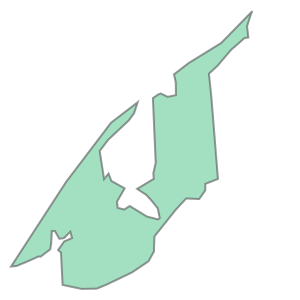

In [43]:
G.nodes[0]['geometry']

In [44]:
nx.write_gpickle(G, "vegetation_graph.pickle")

In [45]:
H = nx.read_gpickle("vegetation_graph.pickle")

14910 39562
[7735, 10852, 434]
[0, 7735, 8348, 2863, 6884, 11209]


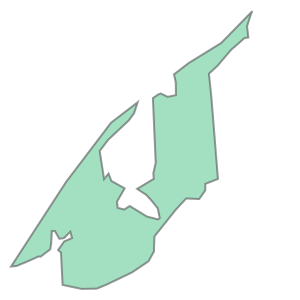

In [46]:
print(H.number_of_nodes(), H.number_of_edges())
print(list(H.adj[0]))
print(list(H.adj[434]))
H.nodes[0]['geometry']